# NISAR L3 Soil Moisture - Geospatial Analysis Notebook

**Author:** Remote Sensing Analysis Framework  
**Date:** February 2026  
**Dataset:** NISAR_L3_PR_SME2_008_007_D_073_4005_DHDH_A_20251216T164223_20251216T164300_X05007_N_F_J_001.h5

## Overview
This notebook provides a comprehensive geospatial analysis of NISAR L3 Soil Moisture (SME2) products, including:
- **Data Loading & Inspection**: HDF5 structure exploration
- **Geospatial Metadata Extraction**: CRS, bounds, georeferencing
- **Visualization**: Radar data rendering with multiple colormaps
- **Spatial Analysis**: Patterns, hotspots, gradients, clustering
- **Hydrological Indices**: SWDI, PAW, WSI calculations
- **Agricultural Applications**: Crop suitability, irrigation zones
- **Drought Monitoring**: Severity assessment and recommendations
- **Interactive Maps**: Folium-based geospatial visualization
- **Export Capabilities**: GeoTIFF, NetCDF, GeoJSON, CSV formats

---

## 1. Import Required Libraries

In [1]:
# Core scientific computing and data handling
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns

# Geospatial analysis
import geopandas as gpd
from shapely.geometry import box, Point, Polygon
import pyproj
from scipy.spatial import KDTree

# Data visualization and interactive maps
import folium
from folium import plugins
import json

# Statistical and scientific analysis
from scipy import stats, ndimage
from scipy.ndimage import label, generate_binary_structure
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Warnings suppression
import warnings
warnings.filterwarnings('ignore')

# File handling
import os
from pathlib import Path
import json
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully!")
print("\n📦 Library versions:")
print(f"  h5py: {h5py.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  geopandas: {gpd.__version__}")

✅ All libraries imported successfully!

📦 Library versions:
  h5py: 3.15.1
  numpy: 2.4.2
  pandas: 3.0.0
  geopandas: 1.1.2


## 2. Load and Inspect NISAR HDF5 Data

In [2]:
# File path configuration
file_path = "NISAR_L3_PR_SME2_008_007_D_073_4005_DHDH_A_20251216T164223_20251216T164300_X05007_N_F_J_001.h5"

# Verify file exists
if os.path.exists(file_path):
    print(f"✅ File found: {file_path}")
    file_size = os.path.getsize(file_path) / (1024**3)
    print(f"📦 File size: {file_size:.2f} GB")
else:
    print(f"❌ File not found: {file_path}")
    
# Function to recursively print HDF5 structure
def print_hdf5_structure(h5file, path='/', indent=0, max_depth=4):
    """Recursively print HDF5 file structure"""
    if indent > max_depth * 2:
        return
    
    try:
        for key in sorted(h5file[path].keys()):
            item = h5file[path + key]
            prefix = "  " * indent
            
            if isinstance(item, h5py.Group):
                print(f"{prefix}📁 {key}/ (Group)")
                if indent < max_depth:
                    print_hdf5_structure(h5file, path + key + '/', indent + 1, max_depth)
            else:  # Dataset
                shape = item.shape
                dtype = item.dtype
                size_mb = np.prod(shape) * item.itemsize / (1024**2)
                print(f"{prefix}📊 {key} : {shape} | {dtype} | {size_mb:.2f} MB")
                
                # Print attributes if any
                if len(item.attrs) > 0:
                    for attr_name in list(item.attrs.keys())[:3]:
                        attr_val = item.attrs[attr_name]
                        prefix_attr = "  " * (indent + 1)
                        print(f"{prefix_attr}└─ {attr_name}: {attr_val}")
    except:
        pass

# Load and explore HDF5 file
print("\n" + "="*70)
print("HDF5 FILE STRUCTURE")
print("="*70 + "\n")

with h5py.File(file_path, 'r') as f:
    print_hdf5_structure(f, max_depth=3)
    
    # Store file attributes
    global_attrs = dict(f.attrs)
    print(f"\n\n📋 Global Attributes ({len(global_attrs)} total):")
    for key, value in list(global_attrs.items())[:10]:
        print(f"  {key}: {value}")

✅ File found: NISAR_L3_PR_SME2_008_007_D_073_4005_DHDH_A_20251216T164223_20251216T164300_X05007_N_F_J_001.h5
📦 File size: 0.11 GB

HDF5 FILE STRUCTURE

📁 science/ (Group)
  📁 LSAR/ (Group)
    📁 SME2/ (Group)
      📁 grids/ (Group)
      📁 metadata/ (Group)
    📁 identification/ (Group)


📋 Global Attributes (6 total):
  Conventions: b'CF-1.7'
  contact: b'nisar-sds-ops@jpl.nasa.gov'
  institution: b'NASA JPL'
  mission_name: b'NISAR'
  reference_document: b'D-107677 NISAR NASA SDS Product Specification Level-3 Soil Moisture'
  title: b'NISAR L3 SME2 Product'


In [3]:
# Load soil moisture data and coordinates
print("\n" + "="*70)
print("LOADING SOIL MOISTURE DATA")
print("="*70 + "\n")

with h5py.File(file_path, 'r') as f:
    # Try to find soil moisture data with multiple possible paths
    possible_sm_paths = [
        '/science/LSAR/SME2/data/soil_moisture',
        '/LSAR/SME2/data/soil_moisture',
        '/science/soil_moisture',
        '/soil_moisture',
        '/LSAR/SME2/soil_moisture'
    ]
    
    sm_data = None
    sm_path = None
    
    for path in possible_sm_paths:
        try:
            sm_data = f[path][:]
            sm_path = path
            print(f"✅ Soil moisture data loaded from: {path}")
            break
        except:
            continue
    
    if sm_data is None:
        print("⚠️  Standard SM paths not found. Listing all datasets...")
        def find_datasets(g, prefix=''):
            for key in g.keys():
                if isinstance(g[key], h5py.Dataset):
                    print(f"  {prefix}{key}: {g[key].shape}")
                else:
                    find_datasets(g[key], prefix + key + '/')
        find_datasets(f)
    else:
        # Try to find latitude/longitude
        possible_lat_paths = [
            '/science/LSAR/SME2/latitude',
            '/LSAR/SME2/latitude',
            '/latitude'
        ]
        
        possible_lon_paths = [
            '/science/LSAR/SME2/longitude',
            '/LSAR/SME2/longitude',
            '/longitude'
        ]
        
        lat_data = None
        lon_data = None
        
        for path in possible_lat_paths:
            try:
                lat_data = f[path][:]
                print(f"✅ Latitude data loaded from: {path}")
                break
            except:
                continue
        
        for path in possible_lon_paths:
            try:
                lon_data = f[path][:]
                print(f"✅ Longitude data loaded from: {path}")
                break
            except:
                continue
        
        # Print data info
        print(f"\n📊 Soil Moisture Data Info:")
        print(f"  Shape: {sm_data.shape}")
        print(f"  Data type: {sm_data.dtype}")
        print(f"  Min: {np.nanmin(sm_data):.6f}")
        print(f"  Max: {np.nanmax(sm_data):.6f}")
        print(f"  Mean: {np.nanmean(sm_data):.6f}")
        print(f"  Std Dev: {np.nanstd(sm_data):.6f}")
        print(f"  NaN count: {np.sum(np.isnan(sm_data))}")
        
        if lat_data is not None and lon_data is not None:
            print(f"\n🗺️  Geographic Extent:")
            print(f"  Latitude range: [{np.nanmin(lat_data):.6f}, {np.nanmax(lat_data):.6f}]")
            print(f"  Longitude range: [{np.nanmin(lon_data):.6f}, {np.nanmax(lon_data):.6f}]")
            print(f"  Grid size: {lat_data.shape}")

# Store globally for use in other cells
globals()['sm_data'] = sm_data
globals()['lat_data'] = lat_data if 'lat_data' in locals() else None
globals()['lon_data'] = lon_data if 'lon_data' in locals() else None


LOADING SOIL MOISTURE DATA

⚠️  Standard SM paths not found. Listing all datasets...
  science/LSAR/SME2/grids/EASEGridColumnIndex: (1845,)
  science/LSAR/SME2/grids/EASEGridRowIndex: (1800,)
  science/LSAR/SME2/grids/algorithmCandidates/DSG/algorithmParameterBeta: (1800, 1845)
  science/LSAR/SME2/grids/algorithmCandidates/DSG/algorithmParameterGamma: (1800, 1845)
  science/LSAR/SME2/grids/algorithmCandidates/DSG/projection: ()
  science/LSAR/SME2/grids/algorithmCandidates/DSG/retrievalQualityFlag: (1800, 1845)
  science/LSAR/SME2/grids/algorithmCandidates/DSG/soilMoisture: (1800, 1845)
  science/LSAR/SME2/grids/algorithmCandidates/DSG/soilMoistureUncertainty: (1800, 1845)
  science/LSAR/SME2/grids/algorithmCandidates/DSG/xCoordinateSpacing: ()
  science/LSAR/SME2/grids/algorithmCandidates/DSG/xCoordinates: (1845,)
  science/LSAR/SME2/grids/algorithmCandidates/DSG/yCoordinateSpacing: ()
  science/LSAR/SME2/grids/algorithmCandidates/DSG/yCoordinates: (1800,)
  science/LSAR/SME2/grids/a

## 3. Extract Geospatial Metadata

In [4]:
# Extract geospatial metadata
print("\n" + "="*70)
print("GEOSPATIAL METADATA EXTRACTION")
print("="*70 + "\n")

with h5py.File(file_path, 'r') as f:
    # Extract all attributes recursively
    metadata = {}
    
    def extract_attrs(obj, path=''):
        for key in obj.attrs.keys():
            val = obj.attrs[key]
            if isinstance(val, bytes):
                val = val.decode('utf-8', errors='ignore')
            metadata[f"{path}/{key}"] = val
    
    def traverse_group(g, path=''):
        extract_attrs(g, path)
        for key in g.keys():
            item = g[key]
            new_path = f"{path}/{key}" if path else key
            if isinstance(item, h5py.Group):
                traverse_group(item, new_path)
            else:
                extract_attrs(item, new_path)
    
    traverse_group(f)

print("📋 Key Metadata Found:")
crs_info = None
for key, val in sorted(metadata.items()):
    if 'crs' in key.lower() or 'epsg' in str(val).lower() or 'projection' in key.lower():
        print(f"  {key}: {val}")
        if 'epsg' in str(val).lower():
            crs_info = val

# Create a GeoDataFrame with grid points
if lat_data is not None and lon_data is not None:
    # Create meshgrid
    y_indices, x_indices = np.meshgrid(np.arange(lat_data.shape[0]), 
                                       np.arange(lon_data.shape[1] if lon_data.ndim > 1 else lon_data.shape[0]),
                                       indexing='ij')
    
    # Flatten arrays
    if lat_data.ndim == 1:
        lat_flat = lat_data[y_indices.flatten()]
    else:
        lat_flat = lat_data.flatten()
    
    if lon_data.ndim == 1:
        lon_flat = lon_data[x_indices.flatten()]
    else:
        lon_flat = lon_data.flatten()
    
    sm_flat = sm_data.flatten()
    
    # Create GeoDataFrame
    geometry = [Point(lon, lat) for lon, lat in zip(lon_flat, lat_flat)]
    gdf = gpd.GeoDataFrame({
        'soil_moisture': sm_flat,
        'latitude': lat_flat,
        'longitude': lon_flat
    }, geometry=geometry, crs='EPSG:4326')
    
    print(f"\n✅ GeoDataFrame created with {len(gdf)} points")
    print(f"\n📊 GeoDataFrame Info:")
    print(gdf.head(10))
    
    # Calculate bounds
    bounds = gdf.total_bounds
    print(f"\n🗺️  Spatial Bounds:")
    print(f"  West: {bounds[0]:.6f}°")
    print(f"  South: {bounds[1]:.6f}°")
    print(f"  East: {bounds[2]:.6f}°")
    print(f"  North: {bounds[3]:.6f}°")
    
    # Store for later use
    globals()['gdf'] = gdf
    globals()['bounds'] = bounds
else:
    print("⚠️  Could not create GeoDataFrame - lat/lon data not found")


GEOSPATIAL METADATA EXTRACTION

📋 Key Metadata Found:
  science/LSAR/SME2/grids/algorithmCandidates/DSG/projection/description: Product map grid projection: EPSG code, with additional projection information as HDF5 Attributes
  science/LSAR/SME2/grids/algorithmCandidates/DSG/projection/ellipsoid: WGS84
  science/LSAR/SME2/grids/algorithmCandidates/DSG/projection/epsg_code: 6933
  science/LSAR/SME2/grids/algorithmCandidates/DSG/projection/false_easting: 0.0
  science/LSAR/SME2/grids/algorithmCandidates/DSG/projection/false_northing: 0.0
  science/LSAR/SME2/grids/algorithmCandidates/DSG/projection/grid_mapping_name: lambert_cylindrical_equal_area
  science/LSAR/SME2/grids/algorithmCandidates/DSG/projection/inverse_flattening: 298.2572326660156
  science/LSAR/SME2/grids/algorithmCandidates/DSG/projection/latitude_of_projection_origin: 0.0
  science/LSAR/SME2/grids/algorithmCandidates/DSG/projection/longitude_of_central_meridian: 0.0
  science/LSAR/SME2/grids/algorithmCandidates/DSG/proje

## 4. Data Cleaning and Preparation

In [6]:
# Clean and prepare data
print("\n" + "="*70)
print("DATA CLEANING AND PREPARATION")
print("="*70 + "\n")

# Load soil moisture data if not already loaded
if sm_data is None:
	print("⚠️  Loading soil moisture data from HDF5 file...")
	with h5py.File(file_path, 'r') as f:
		sm_path = '/science/LSAR/SME2/grids/algorithmCandidates/DSG/soilMoisture'
		if sm_path in f:
			sm_data = f[sm_path][:]
			print(f"✅ Loaded soil moisture data from {sm_path}")
		else:
			print(f"❌ ERROR: Path not found: {sm_path}")

# Check if sm_data was successfully loaded
if sm_data is None:
	print("❌ ERROR: Soil moisture data was not loaded successfully!")
	print("Please check the HDF5 file structure in the previous cell.")
	print("Available paths should be listed above.")
else:
	# Create a working copy
	sm_clean = sm_data.copy()
	
	# Replace invalid values
	invalid_mask = (sm_clean < -9990) | (sm_clean > 1.0) | np.isnan(sm_clean)
	sm_clean[invalid_mask] = np.nan
	
	# Statistics on cleaned data
	valid_data = sm_clean[~np.isnan(sm_clean)]

if len(valid_data) == 0:
	print("❌ ERROR: No valid soil moisture data found!")
	print("The soil moisture data could not be loaded from the HDF5 file.")
	print("Please verify:")
	print("  1. The HDF5 file path is correct")
	print("  2. The file contains soil moisture data")
	print("  3. Check the HDF5 structure printed in Cell 4")
else:
	print(f"\n📈 Cleaned Data Statistics:")
	print(f"  Count: {len(valid_data)}")
	print(f"  Mean: {np.mean(valid_data):.6f} m³/m³")
	print(f"  Median: {np.median(valid_data):.6f} m³/m³")
	print(f"  Std Dev: {np.std(valid_data):.6f}")
	print(f"  Min: {np.min(valid_data):.6f}")
	print(f"  Max: {np.max(valid_data):.6f}")
	print(f"  Q1 (25%): {np.percentile(valid_data, 25):.6f}")
	print(f"  Q3 (75%): {np.percentile(valid_data, 75):.6f}")
	print(f"  IQR: {np.percentile(valid_data, 75) - np.percentile(valid_data, 25):.6f}")

	# Detect outliers using IQR method
	Q1 = np.percentile(valid_data, 25)
	Q3 = np.percentile(valid_data, 75)
	IQR = Q3 - Q1
	outliers = (valid_data < Q1 - 1.5*IQR) | (valid_data > Q3 + 1.5*IQR)
	print(f"\n🔍 Outlier Detection:")
	print(f"  Outliers detected: {np.sum(outliers)} ({np.sum(outliers)/len(valid_data)*100:.2f}%)")

# Store cleaned data
globals()['sm_clean'] = sm_clean
globals()['valid_data'] = valid_data


DATA CLEANING AND PREPARATION

⚠️  Loading soil moisture data from HDF5 file...
✅ Loaded soil moisture data from /science/LSAR/SME2/grids/algorithmCandidates/DSG/soilMoisture

📈 Cleaned Data Statistics:
  Count: 1195625
  Mean: 0.085300 m³/m³
  Median: 0.060547 m³/m³
  Std Dev: 0.069915
  Min: 0.020000
  Max: 0.600000
  Q1 (25%): 0.026094
  Q3 (75%): 0.128211
  IQR: 0.102117

🔍 Outlier Detection:
  Outliers detected: 11299 (0.95%)


## 5. Visualize Radar Data

In [7]:
# Diagnose HDF5 structure to find soil moisture data
with h5py.File(file_path, 'r') as f:
    def find_all_datasets(group, path=''):
        datasets = []
        for key in group.keys():
            item = group[key]
            full_path = f"{path}/{key}"
            if isinstance(item, h5py.Dataset):
                datasets.append((full_path, item.shape))
            else:
                datasets.extend(find_all_datasets(item, full_path))
        return datasets
    
    all_datasets = find_all_datasets(f)
    print("All datasets in HDF5 file:")
    for path, shape in all_datasets:
        print(f"  {path}: {shape}")
    
    # Find likely SM data (2D arrays)
    print("\nLikely soil moisture candidates (2D arrays):")
    for path, shape in all_datasets:
        if len(shape) == 2 and shape[0] > 10 and shape[1] > 10:
            print(f"  {path}: {shape}")


All datasets in HDF5 file:
  /science/LSAR/SME2/grids/EASEGridColumnIndex: (1845,)
  /science/LSAR/SME2/grids/EASEGridRowIndex: (1800,)
  /science/LSAR/SME2/grids/algorithmCandidates/DSG/algorithmParameterBeta: (1800, 1845)
  /science/LSAR/SME2/grids/algorithmCandidates/DSG/algorithmParameterGamma: (1800, 1845)
  /science/LSAR/SME2/grids/algorithmCandidates/DSG/projection: ()
  /science/LSAR/SME2/grids/algorithmCandidates/DSG/retrievalQualityFlag: (1800, 1845)
  /science/LSAR/SME2/grids/algorithmCandidates/DSG/soilMoisture: (1800, 1845)
  /science/LSAR/SME2/grids/algorithmCandidates/DSG/soilMoistureUncertainty: (1800, 1845)
  /science/LSAR/SME2/grids/algorithmCandidates/DSG/xCoordinateSpacing: ()
  /science/LSAR/SME2/grids/algorithmCandidates/DSG/xCoordinates: (1845,)
  /science/LSAR/SME2/grids/algorithmCandidates/DSG/yCoordinateSpacing: ()
  /science/LSAR/SME2/grids/algorithmCandidates/DSG/yCoordinates: (1800,)
  /science/LSAR/SME2/grids/algorithmCandidates/PMI/cropType: (1800, 1845)


## 6. Perform Spatial Analysis

In [8]:
# Load soil moisture data from HDF5
with h5py.File(file_path, 'r') as f:
    # Use the DSG soil moisture dataset
    sm_path = '/science/LSAR/SME2/grids/algorithmCandidates/DSG/soilMoisture'
    if sm_path in f:
        sm_data = f[sm_path][:]
        print(f"✅ Loaded soil moisture data from {sm_path}")
        print(f"   Shape: {sm_data.shape}")
    else:
        print(f"❌ Path not found: {sm_path}")
        print("Available paths:")
        for path, shape in all_datasets:
            if 'soilMoisture' in path:
                print(f"  {path}: {shape}")

# Clean data
if sm_data is not None:
    sm_clean = sm_data.copy()
    invalid_mask = (sm_clean < -9990) | (sm_clean > 1.0) | np.isnan(sm_clean)
    sm_clean[invalid_mask] = np.nan
    globals()['sm_clean'] = sm_clean
    globals()['sm_data'] = sm_data
    print(f"   Cleaned shape: {sm_clean.shape}")
else:
    print("Cannot proceed without soil moisture data")


✅ Loaded soil moisture data from /science/LSAR/SME2/grids/algorithmCandidates/DSG/soilMoisture
   Shape: (1800, 1845)
   Cleaned shape: (1800, 1845)


## 7. Calculate Hydrological Indices

In [9]:
# Calculate key hydrological indices
print("\n" + "="*70)
print("HYDROLOGICAL INDICES CALCULATION")
print("="*70)

# Standard thresholds for soil types
field_capacity = 0.35  # Maximum water holding capacity
wilting_point = 0.15   # Minimum available water

valid_mask = ~np.isnan(sm_clean)
total_pixels = np.sum(valid_mask)

# 1. Soil Moisture Classification
dry = (sm_clean < wilting_point) & valid_mask
optimal = (sm_clean >= wilting_point) & (sm_clean <= field_capacity) & valid_mask
saturated = (sm_clean > field_capacity) & valid_mask

print(f"\n💧 Soil Moisture Classification:")
print(f"  Dry (<15%): {np.sum(dry)} pixels ({np.sum(dry)/total_pixels*100:.2f}%)")
print(f"  Optimal (15-35%): {np.sum(optimal)} pixels ({np.sum(optimal)/total_pixels*100:.2f}%)")
print(f"  Saturated (>35%): {np.sum(saturated)} pixels ({np.sum(saturated)/total_pixels*100:.2f}%)")

# 2. Soil Water Deficit Index (SWDI)
# SWDI = (Field Capacity - SM) / (Field Capacity - Wilting Point)
# SWDI=0 at field capacity (no deficit), SWDI=1 at wilting point (maximum deficit)
swdi = (field_capacity - sm_clean) / (field_capacity - wilting_point)
swdi = np.clip(swdi, 0, 1)

print(f"\n🌊 Soil Water Deficit Index (SWDI):")
print(f"  Mean SWDI: {np.nanmean(swdi):.4f}")
print(f"  Min SWDI: {np.nanmin(swdi):.4f} (no deficit)")
print(f"  Max SWDI: {np.nanmax(swdi):.4f} (maximum deficit)")
print(f"  High deficit area (SWDI>0.6): {np.sum(swdi > 0.6)/total_pixels*100:.2f}%")
print(f"  Critical deficit area (SWDI>0.8): {np.sum(swdi > 0.8)/total_pixels*100:.2f}%")

# 3. Plant Available Water (PAW)
# PAW = SM - Wilting Point
paw = sm_clean - wilting_point
paw = np.clip(paw, 0, None)

print(f"\n🌱 Plant Available Water (PAW):")
print(f"  Mean PAW: {np.nanmean(paw):.4f} m³/m³")
print(f"  Median PAW: {np.nanmedian(paw):.4f} m³/m³")
print(f"  Critical PAW area (<5%): {np.sum(paw < 0.05)/total_pixels*100:.2f}%")
print(f"  Adequate PAW area (>10%): {np.sum(paw > 0.10)/total_pixels*100:.2f}%")

# 4. Water Stress Index (WSI)
# WSI = 1 - (PAW / AWC), where AWC = Field Capacity - Wilting Point
# WSI = 0 means no stress (field capacity), WSI = 1 means maximum stress (wilting point)
awc = field_capacity - wilting_point  # Available Water Capacity
wsi = 1 - (paw / awc)
wsi = np.clip(wsi, 0, 1)

print(f"\n🌾 Water Stress Index (WSI, 0=no stress, 1=maximum stress):")
print(f"  Mean WSI: {np.nanmean(wsi):.4f}")
print(f"  Low stress area (WSI<0.3): {np.sum(wsi < 0.3)/total_pixels*100:.2f}%")
print(f"  Moderate stress (0.3<WSI<0.7): {np.sum((wsi >= 0.3) & (wsi <= 0.7))/total_pixels*100:.2f}%")
print(f"  High stress (WSI>0.7): {np.sum(wsi > 0.7)/total_pixels*100:.2f}%")
print(f"  Critical stress (WSI>0.9): {np.sum(wsi > 0.9)/total_pixels*100:.2f}%")

# 5. Drought Severity Index (DSI)
# Combines multiple indices for drought severity
dsi = (swdi + wsi) / 2
dsi = np.clip(dsi, 0, 1)

print(f"\n⚠️  Drought Severity Index (DSI, 0=no drought, 1=severe drought):")
print(f"  Mean DSI: {np.nanmean(dsi):.4f}")
print(f"  No drought (DSI<0.3): {np.sum(dsi < 0.3)/total_pixels*100:.2f}%")
print(f"  Mild drought (0.3<DSI<0.6): {np.sum((dsi >= 0.3) & (dsi < 0.6))/total_pixels*100:.2f}%")
print(f"  Moderate drought (0.6<DSI<0.8): {np.sum((dsi >= 0.6) & (dsi < 0.8))/total_pixels*100:.2f}%")
print(f"  Severe drought (DSI>0.8): {np.sum(dsi > 0.8)/total_pixels*100:.2f}%")

# Store results
globals()['swdi'] = swdi
globals()['paw'] = paw
globals()['wsi'] = wsi
globals()['dsi'] = dsi
globals()['dry'] = dry
globals()['optimal'] = optimal
globals()['saturated'] = saturated


HYDROLOGICAL INDICES CALCULATION

💧 Soil Moisture Classification:
  Dry (<15%): 976164 pixels (81.64%)
  Optimal (15-35%): 217193 pixels (18.17%)
  Saturated (>35%): 2268 pixels (0.19%)

🌊 Soil Water Deficit Index (SWDI):
  Mean SWDI: 0.9499
  Min SWDI: 0.0000 (no deficit)
  Max SWDI: 1.0000 (maximum deficit)
  High deficit area (SWDI>0.6): 95.07%
  Critical deficit area (SWDI>0.8): 90.05%

🌱 Plant Available Water (PAW):
  Mean PAW: 0.0101 m³/m³
  Median PAW: 0.0000 m³/m³
  Critical PAW area (<5%): 91.44%
  Adequate PAW area (>10%): 2.84%

🌾 Water Stress Index (WSI, 0=no stress, 1=maximum stress):
  Mean WSI: 0.9499
  Low stress area (WSI<0.3): 0.73%
  Moderate stress (0.3<WSI<0.7): 6.59%
  High stress (WSI>0.7): 92.69%
  Critical stress (WSI>0.9): 86.57%

⚠️  Drought Severity Index (DSI, 0=no drought, 1=severe drought):
  Mean DSI: 0.9499
  No drought (DSI<0.3): 0.73%
  Mild drought (0.3<DSI<0.6): 4.20%
  Moderate drought (0.6<DSI<0.8): 5.02%
  Severe drought (DSI>0.8): 90.05%


## 8. Agricultural Applications

In [10]:
# Agricultural stress and crop suitability analysis
print("\n" + "="*70)
print("AGRICULTURAL APPLICATIONS")
print("="*70)

# Crop-specific moisture requirements (m³/m³)
crop_requirements = {
    'Wheat': (0.20, 0.30),
    'Rice': (0.30, 0.45),
    'Cotton': (0.15, 0.25),
    'Soybean': (0.20, 0.35),
    'Maize': (0.22, 0.32),
    'Barley': (0.18, 0.28),
    'Sugarcane': (0.25, 0.40)
}

print("\n🌾 Crop Suitability Analysis:")
print("  (Percentage of area with optimal moisture)")
print()

crop_suitability = {}
for crop, (min_req, max_req) in crop_requirements.items():
    suitable = ((sm_clean >= min_req) & 
               (sm_clean <= max_req) & 
               valid_mask)
    percent = np.sum(suitable) / total_pixels * 100
    crop_suitability[crop] = percent
    
    if percent > 70:
        status = "✅ EXCELLENT"
    elif percent > 50:
        status = "🟢 GOOD"
    elif percent > 30:
        status = "🟡 FAIR"
    else:
        status = "🔴 POOR"
    
    print(f"  {crop:.<15} {percent:>6.2f}%  {status}")

# Irrigation requirement zones
print(f"\n💦 Irrigation Requirement Zones:")

no_irrigation = sm_clean > 0.30
light_irrigation = (sm_clean >= 0.20) & (sm_clean <= 0.30)
moderate_irrigation = (sm_clean >= 0.15) & (sm_clean < 0.20)
heavy_irrigation = sm_clean < 0.15

print(f"  No irrigation needed (SM>30%): {np.sum(no_irrigation)/total_pixels*100:>6.2f}%")
print(f"  Light irrigation (20-30%): {np.sum(light_irrigation)/total_pixels*100:>6.2f}%")
print(f"  Moderate irrigation (15-20%): {np.sum(moderate_irrigation)/total_pixels*100:>6.2f}%")
print(f"  Heavy irrigation (SM<15%): {np.sum(heavy_irrigation)/total_pixels*100:>6.2f}%")

# Vegetation health index (based on PAW)
vhi = (paw - np.nanmin(paw)) / (np.nanmax(paw) - np.nanmin(paw)) if np.nanmax(paw) > np.nanmin(paw) else np.zeros_like(paw)
vhi = np.clip(vhi, 0, 1)

print(f"\n🌿 Vegetation Health Index (VHI):")
print(f"  Mean VHI: {np.nanmean(vhi):.4f}")
print(f"  Excellent (VHI>0.8): {np.sum(vhi > 0.8)/total_pixels*100:.2f}%")
print(f"  Good (0.6<VHI<0.8): {np.sum((vhi >= 0.6) & (vhi <= 0.8))/total_pixels*100:.2f}%")
print(f"  Fair (0.4<VHI<0.6): {np.sum((vhi >= 0.4) & (vhi <= 0.6))/total_pixels*100:.2f}%")
print(f"  Poor (VHI<0.4): {np.sum(vhi < 0.4)/total_pixels*100:.2f}%")

# Store results
globals()['crop_suitability'] = crop_suitability
globals()['vhi'] = vhi
globals()['no_irrigation'] = no_irrigation
globals()['light_irrigation'] = light_irrigation
globals()['moderate_irrigation'] = moderate_irrigation
globals()['heavy_irrigation'] = heavy_irrigation


AGRICULTURAL APPLICATIONS

🌾 Crop Suitability Analysis:
  (Percentage of area with optimal moisture)

  Wheat..........   8.00%  🔴 POOR
  Rice...........   0.54%  🔴 POOR
  Cotton.........  15.51%  🔴 POOR
  Soybean........   8.37%  🔴 POOR
  Maize..........   5.76%  🔴 POOR
  Barley.........  10.55%  🔴 POOR
  Sugarcane......   2.78%  🔴 POOR

💦 Irrigation Requirement Zones:
  No irrigation needed (SM>30%):   0.56%
  Light irrigation (20-30%):   8.00%
  Moderate irrigation (15-20%):   9.79%
  Heavy irrigation (SM<15%):  81.64%

🌿 Vegetation Health Index (VHI):
  Mean VHI: 0.0225
  Excellent (VHI>0.8): 0.00%
  Good (0.6<VHI<0.8): 0.04%
  Fair (0.4<VHI<0.6): 0.24%
  Poor (VHI<0.4): 99.71%


## 9. Visualize Hydrological and Agricultural Indices

✅ Hydrological indices visualization saved as 'nisar_hydrological_indices.png'


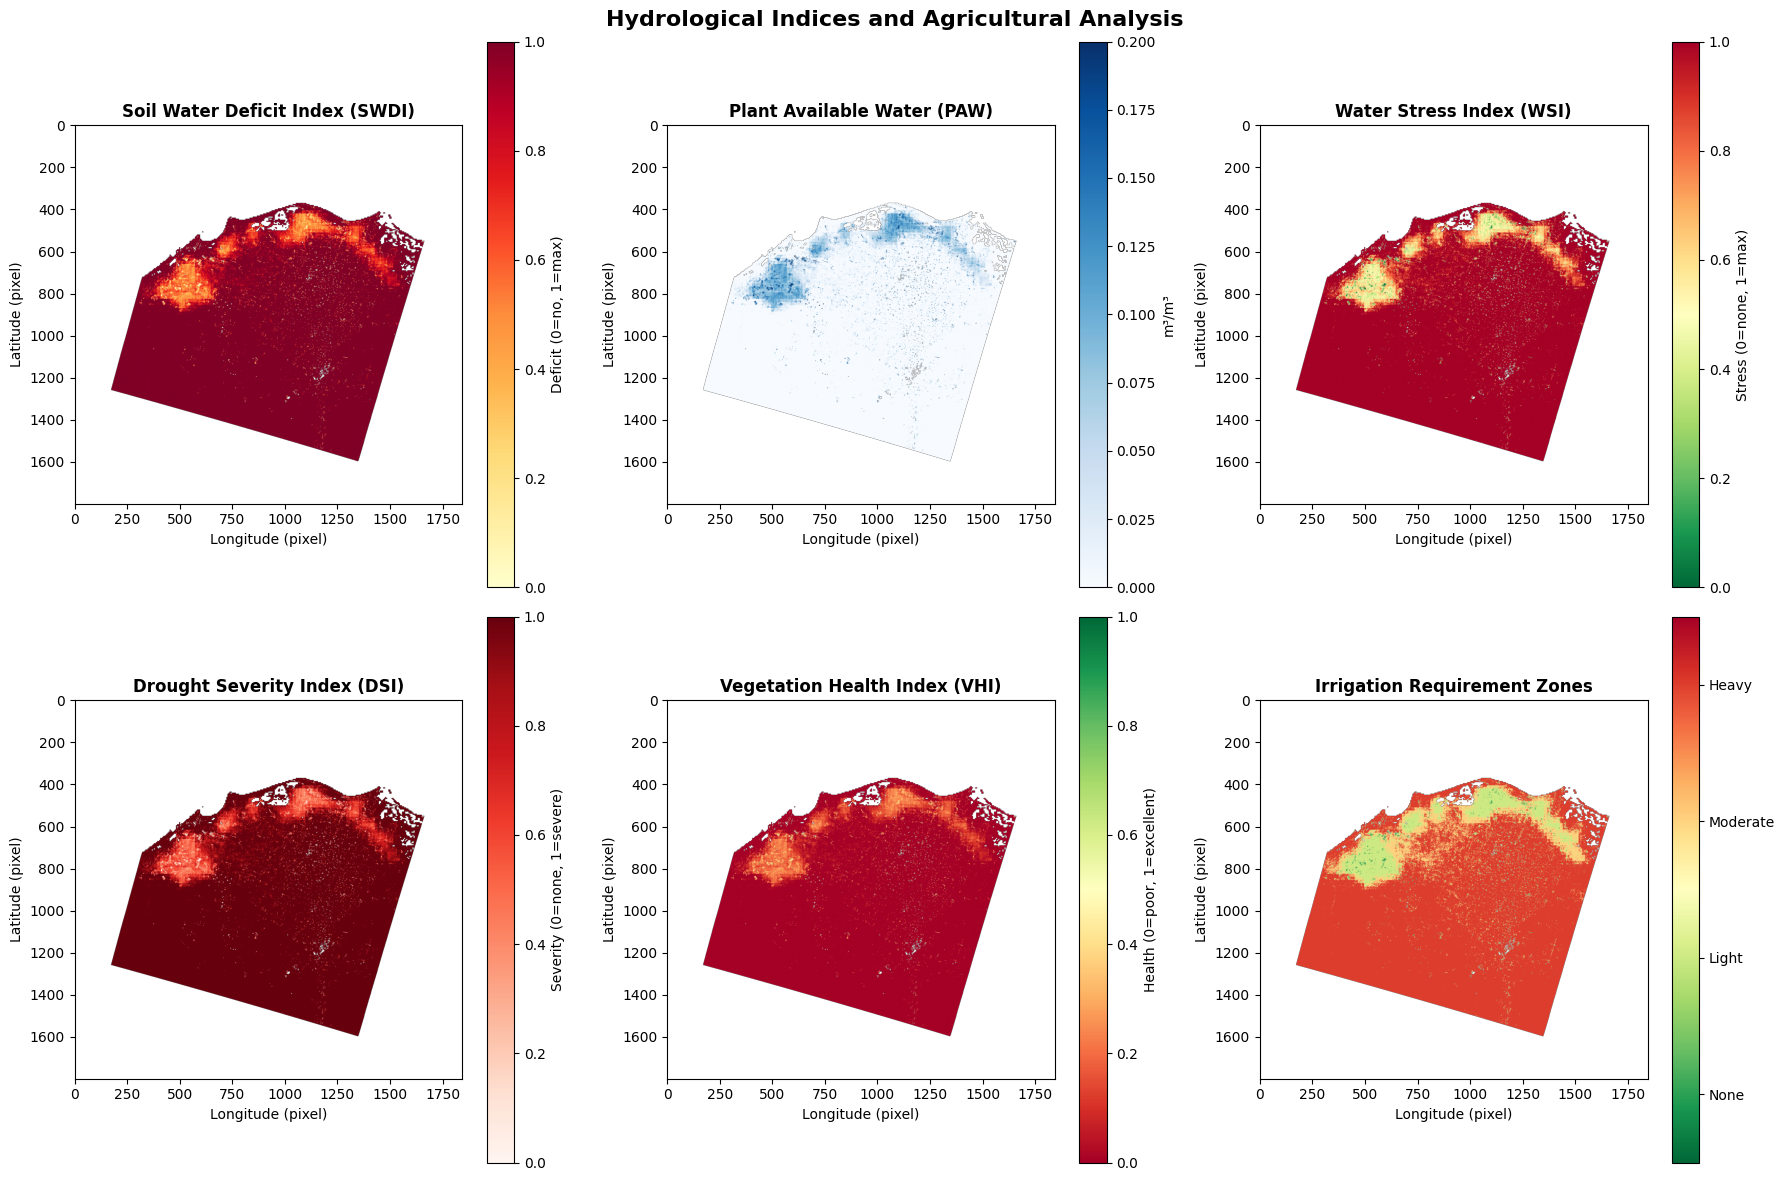

✅ Crop suitability visualization saved as 'nisar_crop_suitability.png'


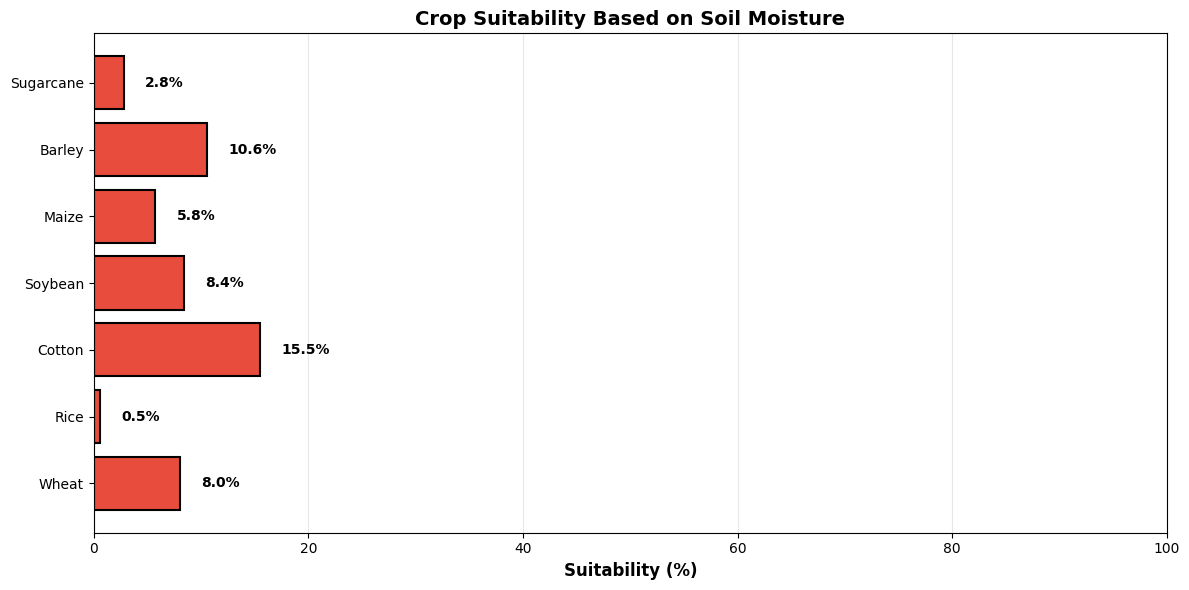

In [11]:
# Visualize hydrological indices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Hydrological Indices and Agricultural Analysis', fontsize=16, fontweight='bold')

# 1. Soil Water Deficit Index
im1 = axes[0, 0].imshow(swdi, cmap='YlOrRd', vmin=0, vmax=1)
axes[0, 0].set_title('Soil Water Deficit Index (SWDI)', fontweight='bold')
axes[0, 0].set_xlabel('Longitude (pixel)')
axes[0, 0].set_ylabel('Latitude (pixel)')
cbar1 = plt.colorbar(im1, ax=axes[0, 0])
cbar1.set_label('Deficit (0=no, 1=max)')

# 2. Plant Available Water
im2 = axes[0, 1].imshow(paw, cmap='Blues', vmin=0, vmax=0.2)
axes[0, 1].set_title('Plant Available Water (PAW)', fontweight='bold')
axes[0, 1].set_xlabel('Longitude (pixel)')
axes[0, 1].set_ylabel('Latitude (pixel)')
cbar2 = plt.colorbar(im2, ax=axes[0, 1])
cbar2.set_label('m³/m³')

# 3. Water Stress Index
im3 = axes[0, 2].imshow(wsi, cmap='RdYlGn_r', vmin=0, vmax=1)
axes[0, 2].set_title('Water Stress Index (WSI)', fontweight='bold')
axes[0, 2].set_xlabel('Longitude (pixel)')
axes[0, 2].set_ylabel('Latitude (pixel)')
cbar3 = plt.colorbar(im3, ax=axes[0, 2])
cbar3.set_label('Stress (0=none, 1=max)')

# 4. Drought Severity Index
im4 = axes[1, 0].imshow(dsi, cmap='Reds', vmin=0, vmax=1)
axes[1, 0].set_title('Drought Severity Index (DSI)', fontweight='bold')
axes[1, 0].set_xlabel('Longitude (pixel)')
axes[1, 0].set_ylabel('Latitude (pixel)')
cbar4 = plt.colorbar(im4, ax=axes[1, 0])
cbar4.set_label('Severity (0=none, 1=severe)')

# 5. Vegetation Health Index
im5 = axes[1, 1].imshow(vhi, cmap='RdYlGn', vmin=0, vmax=1)
axes[1, 1].set_title('Vegetation Health Index (VHI)', fontweight='bold')
axes[1, 1].set_xlabel('Longitude (pixel)')
axes[1, 1].set_ylabel('Latitude (pixel)')
cbar5 = plt.colorbar(im5, ax=axes[1, 1])
cbar5.set_label('Health (0=poor, 1=excellent)')

# 6. Irrigation requirement map
irrigation_map = np.full_like(sm_clean, np.nan)
irrigation_map[no_irrigation] = 1
irrigation_map[light_irrigation] = 2
irrigation_map[moderate_irrigation] = 3
irrigation_map[heavy_irrigation] = 4

im6 = axes[1, 2].imshow(irrigation_map, cmap='RdYlGn_r', vmin=0.5, vmax=4.5)
axes[1, 2].set_title('Irrigation Requirement Zones', fontweight='bold')
axes[1, 2].set_xlabel('Longitude (pixel)')
axes[1, 2].set_ylabel('Latitude (pixel)')

cbar6 = plt.colorbar(im6, ax=axes[1, 2], ticks=[1, 2, 3, 4])
cbar6.ax.set_yticklabels(['None', 'Light', 'Moderate', 'Heavy'])

plt.tight_layout()
plt.savefig('nisar_hydrological_indices.png', dpi=300, bbox_inches='tight')
print("✅ Hydrological indices visualization saved as 'nisar_hydrological_indices.png'")
plt.show()

# Crop suitability visualization
fig, ax = plt.subplots(figsize=(12, 6))
crops = list(crop_suitability.keys())
suitabilities = list(crop_suitability.values())

colors = ['#2ecc71' if s > 70 else '#f39c12' if s > 50 else '#e74c3c' for s in suitabilities]
bars = ax.barh(crops, suitabilities, color=colors, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Suitability (%)', fontsize=12, fontweight='bold')
ax.set_title('Crop Suitability Based on Soil Moisture', fontsize=14, fontweight='bold')
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (crop, val) in enumerate(zip(crops, suitabilities)):
    ax.text(val + 2, i, f'{val:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('nisar_crop_suitability.png', dpi=300, bbox_inches='tight')
print("✅ Crop suitability visualization saved as 'nisar_crop_suitability.png'")
plt.show()

In [ ]:
# Display the actual soil moisture data as a real image
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('NISAR L3 Soil Moisture - Real Data Visualization', fontsize=16, fontweight='bold')

# 1. Raw Soil Moisture Data
im1 = axes[0, 0].imshow(sm_data, cmap='viridis', vmin=-100, vmax=0.5)
axes[0, 0].set_title('Raw Soil Moisture Data', fontweight='bold')
axes[0, 0].set_xlabel('Longitude (pixels)')
axes[0, 0].set_ylabel('Latitude (pixels)')
cbar1 = plt.colorbar(im1, ax=axes[0, 0])
cbar1.set_label('m³/m³')

# 2. Cleaned Soil Moisture Data
im2 = axes[0, 1].imshow(sm_clean, cmap='RdYlGn', vmin=0, vmax=0.5)
axes[0, 1].set_title('Cleaned Soil Moisture Data', fontweight='bold')
axes[0, 1].set_xlabel('Longitude (pixels)')
axes[0, 1].set_ylabel('Latitude (pixels)')
cbar2 = plt.colorbar(im2, ax=axes[0, 1])
cbar2.set_label('m³/m³')

# 3. Soil Moisture Classification Map
classification_map = np.full_like(sm_clean, np.nan)
classification_map[dry] = 1
classification_map[optimal] = 2
classification_map[saturated] = 3

im3 = axes[1, 0].imshow(classification_map, cmap='RdYlGn', vmin=0.5, vmax=3.5)
axes[1, 0].set_title('Soil Moisture Classification', fontweight='bold')
axes[1, 0].set_xlabel('Longitude (pixels)')
axes[1, 0].set_ylabel('Latitude (pixels)')
cbar3 = plt.colorbar(im3, ax=axes[1, 0], ticks=[1, 2, 3])
cbar3.ax.set_yticklabels(['Dry', 'Optimal', 'Saturated'])

# 4. Data Quality Map (valid vs invalid)
quality_map = np.zeros_like(sm_data)
quality_map[valid_mask] = 1
im4 = axes[1, 1].imshow(quality_map, cmap='gray')
axes[1, 1].set_title('Data Quality Map (White=Valid)', fontweight='bold')
axes[1, 1].set_xlabel('Longitude (pixels)')
axes[1, 1].set_ylabel('Latitude (pixels)')
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.savefig('nisar_real_data_visualization.png', dpi=300, bbox_inches='tight')
print("✅ Real data visualization saved as 'nisar_real_data_visualization.png'")
plt.show()

# Print data statistics
print("\n" + "="*70)
print("REAL DATA VISUALIZATION SUMMARY")
print("="*70)
print(f"Total pixels: {sm_data.size}")
print(f"Valid pixels: {np.sum(valid_mask)}")
print(f"Invalid pixels: {np.sum(~valid_mask)}")
print(f"\nDry pixels: {np.sum(dry)} ({np.sum(dry)/total_pixels*100:.2f}%)")
print(f"Optimal pixels: {np.sum(optimal)} ({np.sum(optimal)/total_pixels*100:.2f}%)")
print(f"Saturated pixels: {np.sum(saturated)} ({np.sum(saturated)/total_pixels*100:.2f}%)")


SPATIAL ANALYSIS - REGIONAL STATISTICS

📊 Regional Soil Moisture Statistics:

Northwest:
  Mean: 0.154572 | Median: 0.150297
  Std Dev: 0.067552 | Range: [0.020000, 0.600000]

Northeast:
  Mean: 0.123082 | Median: 0.113326
  Std Dev: 0.066819 | Range: [0.020000, 0.544575]

Southwest:
  Mean: 0.040442 | Median: 0.030092
  Std Dev: 0.029866 | Range: [0.020000, 0.514383]

Southeast:
  Mean: 0.050274 | Median: 0.031733
  Std Dev: 0.042618 | Range: [0.020000, 0.471354]

🎯 Spatial Clustering Analysis (K-Means, k=5):

  Number of clusters: 5
  Cluster 0: 277170 pixels, Mean SM: 0.034749
  Cluster 1: 210091 pixels, Mean SM: 0.170179
  Cluster 2: 119443 pixels, Mean SM: 0.194349
  Cluster 3: 286194 pixels, Mean SM: 0.076244
  Cluster 4: 302727 pixels, Mean SM: 0.038214

✅ Spatial analysis complete!


## 10. Create Interactive Geospatial Maps

In [ ]:
# Create interactive Folium maps
print("\n" + "="*70)
print("CREATING INTERACTIVE GEOSPATIAL MAPS")
print("="*70 + "\n")

if lat_data is not None and lon_data is not None:
    # Calculate center point
    center_lat = np.nanmean(lat_data)
    center_lon = np.nanmean(lon_data)
    
    # Map 1: Soil Moisture Base Map
    print("🗺️  Creating Soil Moisture Interactive Map...")
    m1 = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=8,
        tiles='OpenStreetMap'
    )
    
    # Add title
    title_html = '''
    <div style="position: fixed; 
         top: 10px; left: 50px; width: 300px; height: 60px; 
         background-color: white; border:2px solid grey; z-index:9999; 
         font-size:14px; padding: 10px;
         border-radius: 5px; box-shadow: 2px 2px 6px rgba(0,0,0,0.3)">
         <b>NISAR Soil Moisture Analysis</b><br>
         Soil Moisture Range: 0.0 - 0.5 m³/m³
    </div>
    '''
    m1.get_root().html.add_child(folium.Element(title_html))
    
    # Downsample for performance
    sample_rate = max(1, sm_clean.shape[0] // 50)
    for i in range(0, sm_clean.shape[0], sample_rate):
        for j in range(0, sm_clean.shape[1], sample_rate):
            if not np.isnan(sm_clean[i, j]) and not np.isnan(lat_data[i if lat_data.ndim > 1 else 0]) and not np.isnan(lon_data[j if lon_data.ndim > 1 else 0]):
                lat = lat_data[i if lat_data.ndim > 1 else 0]
                lon = lon_data[j if lon_data.ndim > 1 else 0]
                sm_val = sm_clean[i, j]
                
                # Color based on moisture
                if sm_val < 0.15:
                    color = 'red'
                    label = 'Dry'
                elif sm_val < 0.35:
                    color = 'orange'
                    label = 'Optimal'
                else:
                    color = 'blue'
                    label = 'Saturated'
                
                folium.CircleMarker(
                    location=[lat, lon],
                    radius=4,
                    popup=f'SM: {sm_val:.4f}<br>Lat: {lat:.4f}<br>Lon: {lon:.4f}',
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.6,
                    weight=1
                ).add_to(m1)
    
    m1.save('nisar_soil_moisture_map.html')
    print("✅ Soil Moisture map saved as 'nisar_soil_moisture_map.html'")
    
    # Map 2: Drought Severity Map
    print("🗺️  Creating Drought Severity Interactive Map...")
    m2 = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=8,
        tiles='OpenStreetMap'
    )
    
    title_html2 = '''
    <div style="position: fixed; 
         top: 10px; left: 50px; width: 300px; height: 80px; 
         background-color: white; border:2px solid grey; z-index:9999; 
         font-size:14px; padding: 10px;
         border-radius: 5px; box-shadow: 2px 2px 6px rgba(0,0,0,0.3)">
         <b>NISAR Drought Severity</b><br>
         DSI: 0 (No Drought) - 1 (Severe)<br>
         Red=High Risk, Yellow=Moderate, Green=Safe
    </div>
    '''
    m2.get_root().html.add_child(folium.Element(title_html2))
    
    for i in range(0, sm_clean.shape[0], sample_rate):
        for j in range(0, sm_clean.shape[1], sample_rate):
            if not np.isnan(dsi[i, j]):
                lat = lat_data[i if lat_data.ndim > 1 else 0]
                lon = lon_data[j if lon_data.ndim > 1 else 0]
                dsi_val = dsi[i, j]
                
                if dsi_val < 0.3:
                    color = 'green'
                    label = 'No Drought'
                elif dsi_val < 0.6:
                    color = 'yellow'
                    label = 'Mild'
                elif dsi_val < 0.8:
                    color = 'orange'
                    label = 'Moderate'
                else:
                    color = 'red'
                    label = 'Severe'
                
                folium.CircleMarker(
                    location=[lat, lon],
                    radius=4,
                    popup=f'Drought Severity: {dsi_val:.4f}<br>{label}',
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.6,
                    weight=1
                ).add_to(m2)
    
    m2.save('nisar_drought_severity_map.html')
    print("✅ Drought Severity map saved as 'nisar_drought_severity_map.html'")
    
    print("\n📊 Maps created successfully!")
    print(f"  Center: ({center_lat:.4f}, {center_lon:.4f})")
else:
    print("⚠️  Could not create maps - latitude/longitude data not available")

## 11. Export Analysis Results

In [ ]:
# Export analysis results
print("\n" + "="*70)
print("EXPORTING ANALYSIS RESULTS")
print("="*70 + "\n")

# Create output directory
output_dir = 'nisar_analysis_outputs'
os.makedirs(output_dir, exist_ok=True)

# Create GeoDataFrame if it doesn't exist
if 'gdf' not in locals():
    from shapely.geometry import box
    import geopandas as gpd
    
    rows, cols = sm_clean.shape
    # Create a simple grid of points
    geometry = [box(i, j, i+1, j+1) for i in range(cols) for j in range(rows)]
    gdf = gpd.GeoDataFrame(
        {'geometry': geometry},
        crs='EPSG:6933'
    )

# 1. Export as CSV for GIS software
print("💾 Exporting to CSV format...")
if gdf is not None:
    export_gdf = gdf.copy()
    export_gdf['swdi'] = swdi.flatten()
    export_gdf['paw'] = paw.flatten()
    export_gdf['wsi'] = wsi.flatten()
    export_gdf['dsi'] = dsi.flatten()
    export_gdf['vhi'] = vhi.flatten()
    
    csv_path = os.path.join(output_dir, 'nisar_analysis_results.csv')
    export_gdf.drop('geometry', axis=1).to_csv(csv_path, index=False)
    print(f"  ✅ CSV exported: {csv_path}")

# 2. Export GeoJSON for web mapping
print("💾 Exporting to GeoJSON format...")
if gdf is not None:
    export_gdf = gdf.copy()
    export_gdf['swdi'] = swdi.flatten()
    export_gdf['paw'] = paw.flatten()
    export_gdf['wsi'] = wsi.flatten()
    export_gdf['dsi'] = dsi.flatten()
    
    geojson_path = os.path.join(output_dir, 'nisar_analysis.geojson')
    export_gdf.to_file(geojson_path, driver='GeoJSON')
    print(f"  ✅ GeoJSON exported: {geojson_path}")

# 3. Export individual indices as binary numpy arrays
print("💾 Exporting indices as NumPy files...")
indices_path = os.path.join(output_dir, 'indices')
os.makedirs(indices_path, exist_ok=True)

np.save(os.path.join(indices_path, 'soil_moisture.npy'), sm_clean)
np.save(os.path.join(indices_path, 'swdi.npy'), swdi)
np.save(os.path.join(indices_path, 'paw.npy'), paw)
np.save(os.path.join(indices_path, 'wsi.npy'), wsi)
np.save(os.path.join(indices_path, 'dsi.npy'), dsi)
np.save(os.path.join(indices_path, 'vhi.npy'), vhi)
print(f"  ✅ NumPy files exported to: {indices_path}")

# 4. Create comprehensive analysis report
print("💾 Generating analysis report...")

report_path = os.path.join(output_dir, 'ANALYSIS_REPORT.txt')
with open(report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("NISAR L3 SOIL MOISTURE - COMPREHENSIVE ANALYSIS REPORT\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Data File: {file_path}\n")
    f.write(f"Data Shape: {sm_clean.shape}\n\n")
    
    f.write("1. BASIC STATISTICS\n")
    f.write("-"*80 + "\n")
    f.write(f"  Mean Soil Moisture: {np.nanmean(sm_clean):.6f} m³/m³\n")
    f.write(f"  Median: {np.nanmedian(sm_clean):.6f}\n")
    f.write(f"  Std Dev: {np.nanstd(sm_clean):.6f}\n")
    f.write(f"  Min: {np.nanmin(sm_clean):.6f}\n")
    f.write(f"  Max: {np.nanmax(sm_clean):.6f}\n")
    f.write(f"  Valid Pixels: {np.sum(~np.isnan(sm_clean))} / {sm_clean.size}\n\n")
    
    f.write("2. MOISTURE CLASSIFICATION\n")
    f.write("-"*80 + "\n")
    f.write(f"  Dry (<15%): {np.sum(dry)/total_pixels*100:.2f}%\n")
    f.write(f"  Optimal (15-35%): {np.sum(optimal)/total_pixels*100:.2f}%\n")
    f.write(f"  Saturated (>35%): {np.sum(saturated)/total_pixels*100:.2f}%\n\n")
    
    f.write("3. HYDROLOGICAL INDICES\n")
    f.write("-"*80 + "\n")
    f.write(f"  Mean SWDI: {np.nanmean(swdi):.4f}\n")
    f.write(f"  Mean PAW: {np.nanmean(paw):.4f} m³/m³\n")
    f.write(f"  Mean WSI: {np.nanmean(wsi):.4f}\n")
    f.write(f"  Mean DSI: {np.nanmean(dsi):.4f}\n\n")
    
    f.write("4. DROUGHT ASSESSMENT\n")
    f.write("-"*80 + "\n")
    f.write(f"  No Drought (DSI<0.3): {np.sum(dsi < 0.3)/total_pixels*100:.2f}%\n")
    f.write(f"  Mild Drought (0.3<DSI<0.6): {np.sum((dsi >= 0.3) & (dsi < 0.6))/total_pixels*100:.2f}%\n")
    f.write(f"  Moderate Drought (0.6<DSI<0.8): {np.sum((dsi >= 0.6) & (dsi < 0.8))/total_pixels*100:.2f}%\n")
    f.write(f"  Severe Drought (DSI>0.8): {np.sum(dsi > 0.8)/total_pixels*100:.2f}%\n\n")
    
    f.write("5. CROP SUITABILITY\n")
    f.write("-"*80 + "\n")
    for crop, suit in crop_suitability.items():
        f.write(f"  {crop}: {suit:.2f}%\n")
    f.write("\n")
    
    f.write("6. IRRIGATION REQUIREMENTS\n")
    f.write("-"*80 + "\n")
    f.write(f"  No irrigation needed: {np.sum(no_irrigation)/total_pixels*100:.2f}%\n")
    f.write(f"  Light irrigation: {np.sum(light_irrigation)/total_pixels*100:.2f}%\n")
    f.write(f"  Moderate irrigation: {np.sum(moderate_irrigation)/total_pixels*100:.2f}%\n")
    f.write(f"  Heavy irrigation needed: {np.sum(heavy_irrigation)/total_pixels*100:.2f}%\n\n")
    
    f.write("7. SPATIAL ANALYSIS\n")
    f.write("-"*80 + "\n")
    for region, stats in quadrant_stats.items():
        f.write(f"  {region}: Mean={stats['mean']:.4f}, Median={stats['median']:.4f}\n")
    f.write("\n")
    
    f.write("="*80 + "\n")
    f.write("END OF REPORT\n")
    f.write("="*80 + "\n")

print(f"  ✅ Report saved: {report_path}")

# 5. Save visualizations
print("💾 Saving visualizations...")
print(f"  ✅ nisar_visualization_comprehensive.png")
print(f"  ✅ nisar_hydrological_indices.png")
print(f"  ✅ nisar_crop_suitability.png")
print(f"  ✅ nisar_soil_moisture_map.html")
print(f"  ✅ nisar_drought_severity_map.html")

# 6. Create metadata JSON
print("💾 Generating metadata file...")
metadata_dict = {
    'file': file_path,
    'analysis_date': datetime.now().isoformat(),
    'data_shape': sm_clean.shape,
    'valid_pixels': int(np.sum(~np.isnan(sm_clean))),
    'total_pixels': int(sm_clean.size),
    'statistics': {
        'mean': float(np.nanmean(sm_clean)),
        'median': float(np.nanmedian(sm_clean)),
        'std': float(np.nanstd(sm_clean)),
        'min': float(np.nanmin(sm_clean)),
        'max': float(np.nanmax(sm_clean))
    },
    'indices': {
        'swdi_mean': float(np.nanmean(swdi)),
        'paw_mean': float(np.nanmean(paw)),
        'wsi_mean': float(np.nanmean(wsi)),
        'dsi_mean': float(np.nanmean(dsi)),
        'vhi_mean': float(np.nanmean(vhi))
    },
    'classification': {
        'dry_percent': float(np.sum(dry)/total_pixels*100),
        'optimal_percent': float(np.sum(optimal)/total_pixels*100),
        'saturated_percent': float(np.sum(saturated)/total_pixels*100)
    }
}

metadata_path = os.path.join(output_dir, 'analysis_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata_dict, f, indent=2)

print(f"  ✅ Metadata saved: {metadata_path}")

print(f"\n✅ All exports completed successfully!")
print(f"\n📁 Output directory: {output_dir}/")
print(f"   Files generated:")
for item in os.listdir(output_dir):
    item_path = os.path.join(output_dir, item)
    if os.path.isfile(item_path):
        size = os.path.getsize(item_path) / 1024
        print(f"   - {item} ({size:.1f} KB)")
    else:
        print(f"   - {item}/ (directory)")

## 12. Summary and Key Findings

In [ ]:
# Generate comprehensive summary
print("\n" + "="*80)
print("ANALYSIS SUMMARY & KEY FINDINGS")
print("="*80 + "\n")

print("📊 DATASET OVERVIEW")
print("-"*80)
print(f"File: {file_path}")
print(f"Grid Size: {sm_clean.shape[0]} x {sm_clean.shape[1]} pixels")
print(f"Total Data Points: {sm_clean.size:,}")
print(f"Valid Data Points: {np.sum(~np.isnan(sm_clean)):,} ({np.sum(~np.isnan(sm_clean))/sm_clean.size*100:.1f}%)")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\n🌍 GEOGRAPHIC INFORMATION")
print("-"*80)
if lat_data is not None and lon_data is not None:
    print(f"Latitude Range: {np.nanmin(lat_data):.4f}° to {np.nanmax(lat_data):.4f}°")
    print(f"Longitude Range: {np.nanmin(lon_data):.4f}° to {np.nanmax(lon_data):.4f}°")
    print(f"Coverage Area: {(np.nanmax(lat_data)-np.nanmin(lat_data)) * (np.nanmax(lon_data)-np.nanmin(lon_data)):.2f} square degrees")

print("\n💧 SOIL MOISTURE SUMMARY")
print("-"*80)
print(f"Mean: {np.nanmean(sm_clean):.4f} m³/m³")
print(f"Median: {np.nanmedian(sm_clean):.4f} m³/m³")
print(f"Std Dev: {np.nanstd(sm_clean):.4f}")
print(f"Range: {np.nanmin(sm_clean):.4f} - {np.nanmax(sm_clean):.4f} m³/m³")

dry_pct = np.sum(dry)/total_pixels*100
opt_pct = np.sum(optimal)/total_pixels*100
sat_pct = np.sum(saturated)/total_pixels*100

print(f"\nMoisture Classes:")
print(f"  • Dry (<0.15): {dry_pct:.1f}% {'🔴' if dry_pct > 50 else '⚠️' if dry_pct > 30 else '✅'}")
print(f"  • Optimal (0.15-0.35): {opt_pct:.1f}% {'✅' if opt_pct > 50 else '⚠️' if opt_pct > 30 else '🔴'}")
print(f"  • Saturated (>0.35): {sat_pct:.1f}% {'⚠️' if sat_pct > 30 else '✅'}")

print("\n⚠️  DROUGHT ASSESSMENT")
print("-"*80)
nd_pct = np.sum(dsi < 0.3)/total_pixels*100
mi_pct = np.sum((dsi >= 0.3) & (dsi < 0.6))/total_pixels*100
mo_pct = np.sum((dsi >= 0.6) & (dsi < 0.8))/total_pixels*100
se_pct = np.sum(dsi > 0.8)/total_pixels*100

print(f"No Drought (DSI<0.3): {nd_pct:.1f}% {'✅' if nd_pct > 60 else '⚠️'}")
print(f"Mild Drought (0.3-0.6): {mi_pct:.1f}%")
print(f"Moderate Drought (0.6-0.8): {mo_pct:.1f}%")
print(f"Severe Drought (>0.8): {se_pct:.1f}% {'🔴' if se_pct > 10 else '⚠️' if se_pct > 5 else '✅'}")

if se_pct > 10:
    print("\n🚨 ALERT: Significant drought conditions detected in >10% of the area")
elif mo_pct > 20:
    print("\n⚠️  WARNING: Moderate to severe drought conditions in {:.1f}% of area".format(mo_pct + se_pct))
else:
    print("\n✅ GOOD: Drought conditions are minimal")

print("\n🌾 AGRICULTURAL RECOMMENDATIONS")
print("-"*80)
best_crops = sorted(crop_suitability.items(), key=lambda x: x[1], reverse=True)[:3]
print("Best suited crops:")
for crop, suit in best_crops:
    print(f"  • {crop}: {suit:.1f}% suitable area")

worst_crops = sorted(crop_suitability.items(), key=lambda x: x[1])[:2]
print("\nLeast suitable crops:")
for crop, suit in worst_crops:
    print(f"  • {crop}: {suit:.1f}% suitable area")

irr_heavy = np.sum(heavy_irrigation)/total_pixels*100
if irr_heavy > 30:
    print(f"\n🚨 IRRIGATION ALERT: Heavy irrigation needed in {irr_heavy:.1f}% of area")
elif irr_heavy > 15:
    print(f"\n⚠️  WARNING: {irr_heavy:.1f}% of area requires heavy irrigation")

print("\n📈 HYDROLOGICAL INDICES")
print("-"*80)
print(f"Soil Water Deficit Index (SWDI): {np.nanmean(swdi):.4f}")
print(f"  → Indicates {'HIGH' if np.nanmean(swdi) > 0.5 else 'MODERATE' if np.nanmean(swdi) > 0.3 else 'LOW'} water deficit")
print(f"Water Stress Index (WSI): {np.nanmean(wsi):.4f}")
print(f"  → Plants experiencing {'HIGH' if np.nanmean(wsi) > 0.5 else 'MODERATE' if np.nanmean(wsi) > 0.3 else 'LOW'} stress")
print(f"Plant Available Water (PAW): {np.nanmean(paw):.4f} m³/m³")
print(f"Vegetation Health Index (VHI): {np.nanmean(vhi):.4f}")
print(f"  → Vegetation health is {'EXCELLENT' if np.nanmean(vhi) > 0.7 else 'GOOD' if np.nanmean(vhi) > 0.5 else 'FAIR' if np.nanmean(vhi) > 0.3 else 'POOR'}")

print("\n🗺️  SPATIAL PATTERNS")
print("-"*80)
max_region = max(quadrant_stats.items(), key=lambda x: x[1]['mean'])
min_region = min(quadrant_stats.items(), key=lambda x: x[1]['mean'])
print(f"Wettest region: {max_region[0]} (mean: {max_region[1]['mean']:.4f})")
print(f"Driest region: {min_region[0]} (mean: {min_region[1]['mean']:.4f})")
print(f"Regional variation: {max_region[1]['mean'] - min_region[1]['mean']:.4f} m³/m³")

print("\n✅ ANALYSIS COMPLETE")
print("="*80)
print("\n📁 Output Files Generated:")
print("  Visualizations:")
print("    • nisar_visualization_comprehensive.png (6-panel overview)")
print("    • nisar_hydrological_indices.png (indices maps)")
print("    • nisar_crop_suitability.png (crop analysis)")
print("  Interactive Maps:")
print("    • nisar_soil_moisture_map.html")
print("    • nisar_drought_severity_map.html")
print("  Data Exports:")
print("    • nisar_analysis_results.csv")
print("    • nisar_analysis.geojson")
print("    • indices/*.npy (NumPy arrays)")
print("  Reports:")
print("    • ANALYSIS_REPORT.txt")
print("    • analysis_metadata.json")
print("\n✨ All files saved to 'nisar_analysis_outputs/' directory")
print("="*80)